# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.7. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

Начнем с импортирования всех нужных библиотек:

In [ ]:
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [1]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt

from tqdm import tqdm
import itertools

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc, roc_auc_score

%matplotlib inline

In [2]:
data = pd.read_csv('users_behavior.csv')

In [3]:
display(data)
data.info()
data.describe()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [4]:
profile = ProfileReport(data, title="Profiling Report")

In [5]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Разбейте данные на выборки

Отделим 50% данных для тестовой выборки:

In [6]:
np.random.seed(12345)

In [7]:
data_train, data_test = train_test_split(data, test_size=0.5) 

В данном случае у нас целевым является столбец 'is_ultra':

In [8]:
features = data_test.drop('is_ultra', axis=1)
target = data_test['is_ultra']

features_train = data_train.drop('is_ultra', axis = 1)
target_train = data_train['is_ultra']

Отделим 25% данных для валидационной выборки:

In [9]:
features_valid, features_test, target_valid, target_test = train_test_split(features, target, test_size=0.5)

In [10]:
print(features.shape, target.shape, features_valid.shape, target_valid.shape, features_test.shape, target_test.shape, features_train.shape, target_train.shape)

(1607, 4) (1607,) (803, 4) (803,) (804, 4) (804,) (1607, 4) (1607,)


## Исследуйте модели

Поскольку строются модели для задачи 'Классификации' и в условии требуется построить наиболее качественную модель, то MSE в данном проекте не потребуется.

Начнем с модели `Случайный лес в регрессии`:

In [11]:
best_params = None
best_result_forest = 0

for params in tqdm(itertools.product(range(10, 21, 1), range(1, 11), range(1, 5))):
    est, depth, min_s_l = params
    model_forest = RandomForestClassifier(n_estimators=est, max_depth=depth, min_samples_leaf=min_s_l)
    model_forest.fit(features_train, target_train)
    prediction = model_forest.predict(features_valid)
    result = accuracy_score(target_valid, prediction)
    if result > best_result_forest:
        best_result_forest = result
        best_params = params
        best_model_forest = model_forest
        
print(f'Результат наилучшей модели = {np.round(best_result_forest, 3)}')
print(f'Кол-во деревьев = {best_params[0]}\nМаксимальная глубина = {best_params[1]}')

440it [00:19, 22.85it/s]

Результат наилучшей модели = 0.819
Кол-во деревьев = 11
Максимальная глубина = 7


Следующая модель: `Дерево решений в регрессии`:

In [12]:
best_model = None
best_result_tree = 0

for params in tqdm(itertools.product(range(1, 6), range(1, 5))):
    depht, min_s_l = params #
    model_tree = DecisionTreeClassifier(max_depth=depht, min_samples_leaf=min_s_l)
    model_tree.fit(features_train, target_train)
    result = model_tree.score(features_valid, target_valid)
    if result > best_result_tree:
        best_result_tree = result
        best_params = params
        best_model_tree = model_tree
        
print(f'Результат наилучшей модели = {np.round(best_result_tree, 3)}')

20it [00:00, 115.01it/s]

Результат наилучшей модели = 0.803


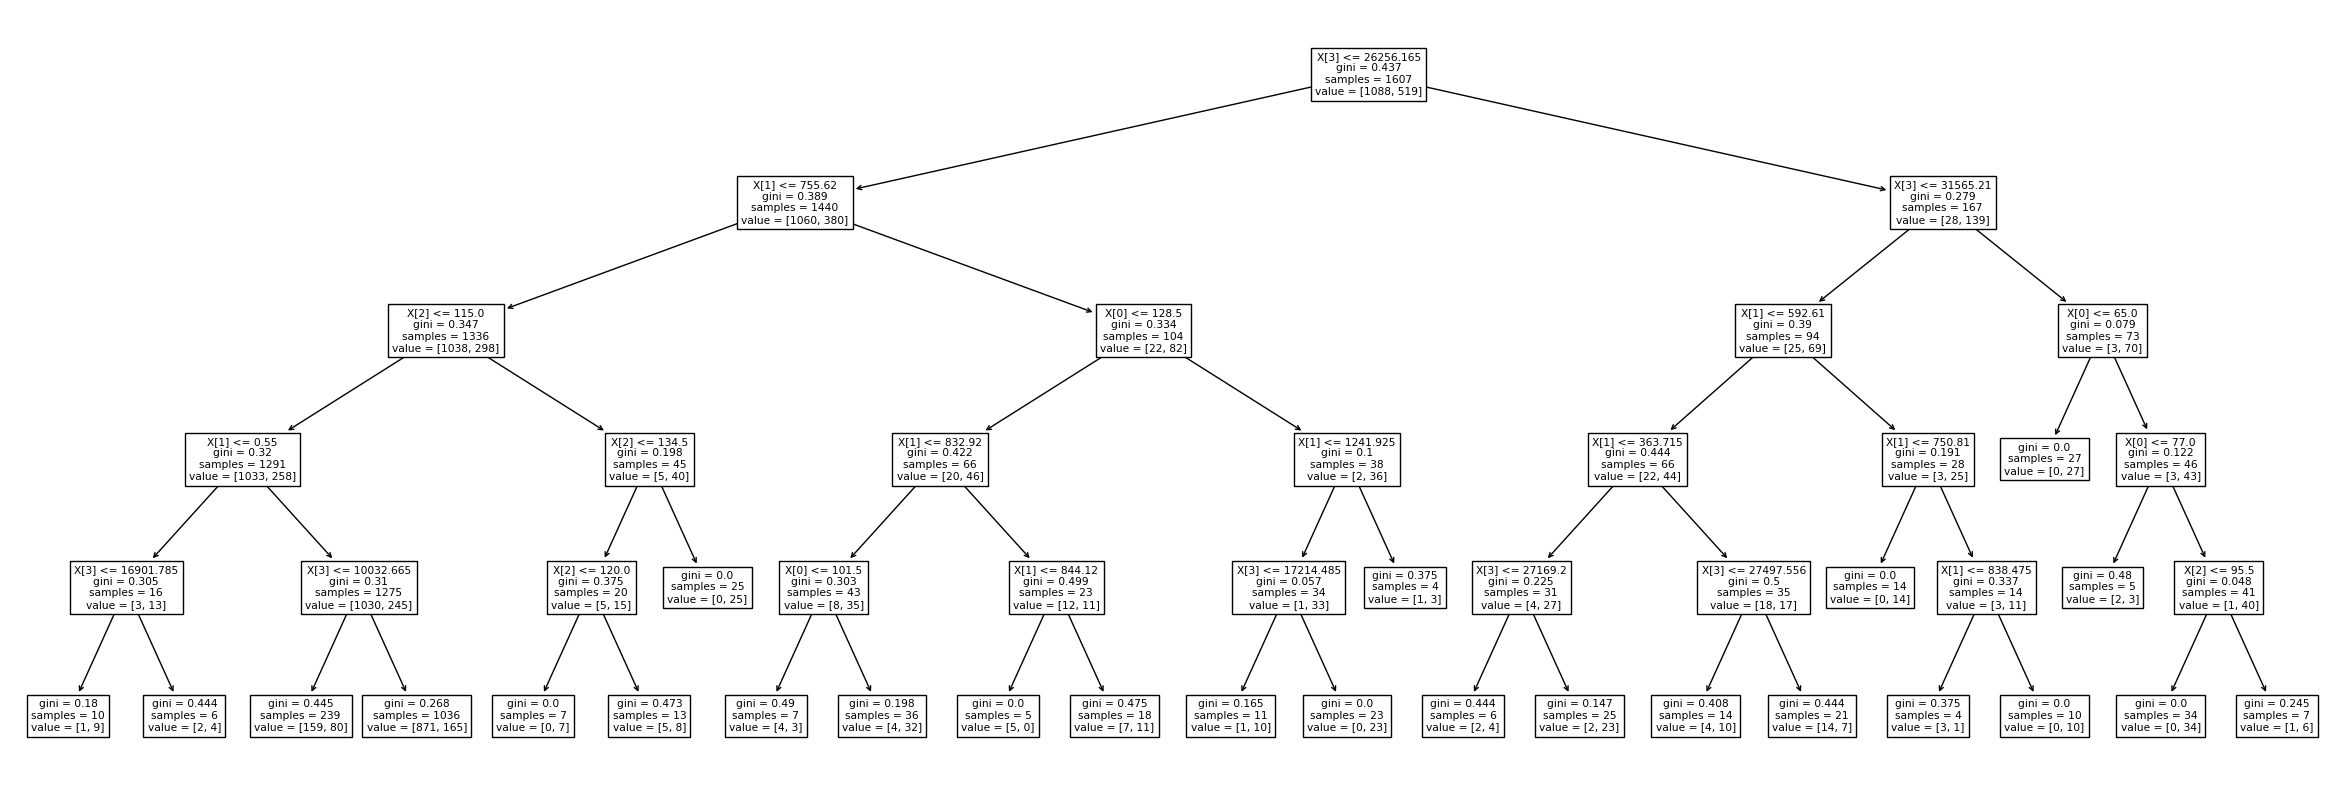

In [13]:
fig, ax = plt.subplots(figsize=(30, 10))
tree.plot_tree(model_tree)
plt.show()

В случае `Дерева решений` качество модели было так же неплохим, но всё же уступающим `Случайному лесу`

Следующая модель: `Логистическая регрессия`:

In [19]:
model_logistic = LogisticRegression()
model_logistic.fit(features_train, target_train)
result_logistic = model_logistic.score(features_valid, target_valid)
print(f'Результат модели логистической регрессии = {np.round(result_logistic, 3)}')

Результат модели логистической регрессии = 0.766


#### Вывод

Точность моделей:
1. Случайный леc: `0.819`
2. Дерево решений: `0.803`
3. Логистическая регрессия: `0.766`

По скорости выполнения модели идут в обратном порядке, от самой быстрой к самой медленной

## Проверьте модель на тестовой выборке

Модель `Случайный лес в регрессии`:

In [14]:
predictions_model_forest = best_model_forest.predict(features_test)
result_forest = best_model_forest.score(features_test, target_test)
print(f'Качество модели Случайный лес(test) = {round(result_forest, 6)}')

Качество модели Случайный лес(test) = 0.809701


Модеь `Дерево решений`:

In [17]:
predictions_model_tree = best_model_tree.predict(features_test)
result_tree = best_model_tree.score(features_test, target_test)
print(f'Качество модели Дерево решенйи(test) = {round(result_tree, 6)}')

Качество модели Дерево решенйи(test) = 0.788557


Модель `Логистическая регрессия`:

In [20]:
predictions_model_logistic = model_logistic.predict(features_test)
result_logic = accuracy_score(target_test, predictions_model_logistic)
print(f'Качестов модели Логистическая регрессия(test) = {round(result_logic, 6)}')

Качестов модели Логистическая регрессия(test) = 0.748756


#### Вывод

Модели:
1. Случайного лес: 0.809701
2. Дерево решений: 0.788557
3. Логистическая регрессия: 0.748756

## Проверьте модели на адекватность

Модель `Случайного леса`

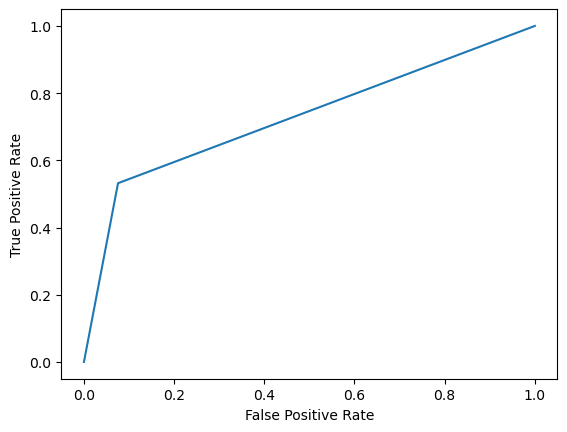

ROC AUC score: 0.7281718580563138


In [21]:
fpr, tpr, thresholds = roc_curve(target_test, predictions_model_forest)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.show()
print(f'ROC AUC score: {roc_auc_score(target_test, predictions_model_forest)}')

Модель `Дерева решений`:

In [22]:
dummy = DummyClassifier(strategy = 'most_frequent')
dummy.fit(features_train, target_train)
dummy_score = dummy.score(features_test, target_test)
print(f'Качество случайной модели: {dummy_score}')
print(f'Качество модели Случайного леса: {result_tree}')

Качество случайной модели: 0.7077114427860697
Качество модели Случайного леса: 0.7885572139303483


Модель `Логистическая регрессия`

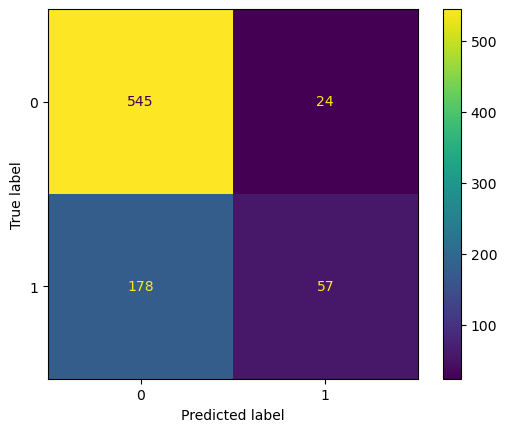

ROC AUC score: 0.6001869648132222


In [23]:
cm = confusion_matrix(target_test, predictions_model_logistic)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()
print(f'ROC AUC score: {roc_auc_score(target_test, predictions_model_logistic)}')

## Вывод

Лучше всего проверку на адекватность прошла модель `Случайного леса`